Here, I'm trying to make a program using NLP, which can identify the writer from the way of writing of the texts.

That project, in my opinion, should be consist of three things :
First, Analyse the data
Second, Modelling 
Third, The results of the model


***First : Analysing the Data***

the steps : 
- Importing Libraries 
- Importing the data
- Checking the missing values
- Visualizing the data
- Perform one hot encoding on author column
- Clean the text data

In [52]:
#Importing Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt #Visualizing the data
import nltk 
import re #To deal with special characters like #
from nltk.corpus import stopwords # to remove stopwords 
from nltk.stem import WordNetLemmatizer # to return word to its original
from nltk.tokenize import word_tokenize # divide strings into lists of substrings
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization,SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder




In [11]:
#Knowing the place of our dataset to importing it
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spooky-author-identification/train.zip
/kaggle/input/spooky-author-identification/test.zip
/kaggle/input/spooky-author-identification/sample_submission.zip


In [16]:
#Importing the data
train_df = pd.read_csv("/kaggle/input/spooky-author-identification/train.zip")
test_df = pd.read_csv('/kaggle/input/spooky-author-identification/test.zip')

In [23]:
#Seeing the train data how it look like
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [22]:
#Checking if there missing values, then printing the number of our test data and train data
print(train_df.isna().sum())
print(test_df.isna().sum())
print('Our train data is : ', len(train_df))
print('Our test data is : ',len(test_df))

id        0
text      0
author    0
dtype: int64
id      0
text    0
dtype: int64
Our train data is :  19579
Our test data is :  8392


In [32]:
x.values

array([7900, 6044, 5635])

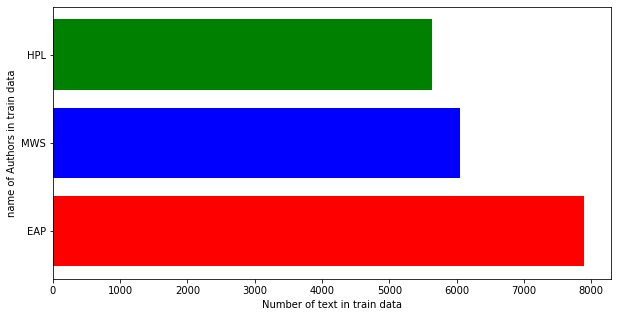

In [38]:
# creating the bar plot
fig = plt.figure(figsize = (10, 5))
plt.barh((train_df['author'].value_counts()).index,(train_df['author'].value_counts()).values,color = ['red','blue','green'])
 
plt.xlabel("Number of text in train data")
plt.ylabel("name of Authors in train data")
plt.show()

In [ ]:
#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'author' column 
encoder_df = pd.DataFrame(encoder.fit_transform(train_df[['author']]).toarray())
encoder_df

In [43]:
#Here, we remove the stopwords in english , split the text, then lemmatize it
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range (0,len(train_df)):
    review = re.sub('[^A-Za-z]',' ',train_df['text'][i])
    review = review.lower()
    review = review.split()
    review = [lemmatizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [49]:
# to create the word embeddings; first, we need to create a dictionary holding each word and its respective vector
embeddings_index = dict()
f = open('../input/glove6b100dtxt/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
train_df['text_after_edit'] = corpus
train_df['tokenized'] = train_df['text_after_edit'].apply(word_tokenize)
train_df.head()

In [ ]:
tok = Tokenizer()
combined  = train_df['text_after_edit'].tolist()
combined[0]

In [56]:
#Creating Embeddings for the texts

max_len_text = 150

tok = Tokenizer()
tok.fit_on_texts(combined)
vocab_size = len(tok.word_index) + 1
encoded_text = tok.texts_to_sequences(combined)
padded_text = pad_sequences(encoded_text, maxlen=max_len_tweet, padding='post')

vocab_size = len(tok.word_index) + 1

text_embedding_matrix = np.zeros((vocab_size, 100))

In [58]:
for word, i in tok.word_index.items():
    t_embedding_vector = embeddings_index.get(word)
    if t_embedding_vector is not None:
        text_embedding_matrix[i] = t_embedding_vector

***Modelling***

here, we began to model our clean data

In [121]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_len_text, embeddings_initializer=Constant(text_embedding_matrix), trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.2))
model.add(BatchNormalization())
# model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# model.add(BatchNormalization())
# model.add(LSTM(20,dropout=0.2, recurrent_dropout=0.2))
# model.add(Dropout(0.3))
#model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='relu'))
optimzer=Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimzer, metrics=['accuracy', 'mae'])

In [122]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 150, 100)          2202100   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 150, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [126]:
model.fit(padded_text, encoder_df.values, epochs = 2)


Epoch 1/2
612/612 [==============================] - 484s 791ms/step - loss: 0.7596 - accuracy: 0.6663 - mae: 0.3941
Epoch 2/2
612/612 [==============================] - 479s 783ms/step - loss: 0.6496 - accuracy: 0.6656 - mae: 0.4422


I did only two epochs because it took a time to finish. I didnt finish the project either by testing it because i do that for practice only. when i reach "model.fit" line and it works. i knew i finished the hard part.
but if you want to continue, you will did the same thing to test data set, then use model.predict to predict the name of the author.
also, i should classify my training data using train_test_split from sklearn to test and train data to test my model.
